<a href="https://colab.research.google.com/github/jduell12/DS-Unit-2-Kaggle-Challenge/blob/main/guidedProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
# If you're on Colab:
if 'google.colab' in sys.modules:
  DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/main/data/'
  !pip install category_encoders==2.*
else:
  DATA_PATH = '../data/'

     |████████████████████████████████| 80 kB 4.9 MB/s 


In [2]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# I. Wrangle Data

In [24]:
def wrangle(fm_path, tv_path=None):
  if tv_path:
    df = pd.merge(pd.read_csv(fm_path, na_values=[0, -2.000000e-08],parse_dates=['date_recorded']), pd.read_csv(tv_path)).set_index('id')
  else:
    df = pd.read_csv(fm_path, na_values=[0, -2.000000e-08], parse_dates=['date_recorded'], index_col='id')
  # drop constant columns 
  df.drop(columns=['recorded_by'], inplace=True)
  # create age feature 
  df['pump_age'] = df['date_recorded'].dt.year - df['construction_year']
  df.drop(columns=['date_recorded'], inplace=True)
  # drop high cardinality columns 
  cutoff = 100
  drop_cols = [col for col in df.select_dtypes('object').columns if df[col].nunique() > 100]
  df.drop(columns = drop_cols, inplace=True)
  # drop duplicate columns 
  dup_cols = [col for col in df.head(15).T.duplicated().index if df.head(15).T.duplicated()[col]]
  df.drop(columns=dup_cols, inplace=True)
  return df

In [25]:
df = wrangle(DATA_PATH + 'waterpumps/train_features.csv', DATA_PATH + 'waterpumps/train_labels.csv')
X_test = wrangle(DATA_PATH + 'waterpumps/test_features.csv')

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 59399 entries, 69572.0 to 26348.0
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             17761 non-null  float64
 1   gps_height             38962 non-null  float64
 2   longitude              57587 non-null  float64
 3   latitude               57587 non-null  float64
 4   num_private            757 non-null    float64
 5   basin                  59399 non-null  object 
 6   region                 59399 non-null  object 
 7   region_code            59399 non-null  int64  
 8   district_code          59376 non-null  float64
 9   population             38019 non-null  float64
 10  public_meeting         56066 non-null  object 
 11  scheme_management      55522 non-null  object 
 12  permit                 56343 non-null  object 
 13  construction_year      38691 non-null  float64
 14  extraction_type        59399 non-null  objec

# II. Split Data 

# Split TV From FM

In [29]:
target = 'status_group'
y = df[target]
X = df.drop(columns=target)

# Training-Validation Split
* Randomized Split

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# III. Establish baseline 

This is a **classification** problem, our baseline will be **accuracy**

In [31]:
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.5425829668132747


# IV. Build Model(s)

* Missing values
* Categorical value 

In [32]:
tree_model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(random_state=42, max_depth=20)
)

tree_model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type',
                                      'waterpoint_type_group...
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                             

In [37]:
rf_model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(random_state=42, n_jobs=-1)
)

rf_model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type',
                                      'waterpoint_type_group...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                 

# V. Check Metrics

In [33]:
print('TREE: Training Accuracy:', tree_model.score(X_train, y_train))
print('TREE: Validation Accuracy:', tree_model.score(X_val, y_val))

TREE: Training Accuracy: 0.9294808392432501
TREE: Validation Accuracy: 0.7631313131313131


In [38]:
print('FOREST: Training Accuracy:', rf_model.score(X_train, y_train))
print('FOREST: Validation Accuracy:', rf_model.score(X_val, y_val))

FOREST: Training Accuracy: 0.9952440076600939
FOREST: Validation Accuracy: 0.8022727272727272


# VI. Tune Model

# VII. Communicate Results 

In [44]:
importances = rf_model.named_steps['randomforestclassifier'].feature_importances_
features = rf_model.named_steps['ordinalencoder'].get_feature_names() # could use X_train.columns instead

feat_imp = pd.Series(importances, index=features).sort_values()

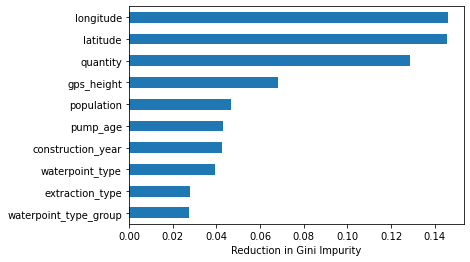

In [49]:
feat_imp.tail(10).plot(kind='barh');
plt.xlabel('Reduction in Gini Impurity');
# can't really tell if this is a positive or negative impact on the water pumps